In [117]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from scipy.optimize import curve_fit
import matplotlib.dates as mdates
from datetime import datetime, timezone, timedelta
import os
import scipy
import pandas as pd
import re

plt.figure()
hep.set_style(hep.style.CMS)
hep.set_style("CMS")

def linear(x, a, b):
    return a*x + b

def quad(x, a, b, c):
    return a*x**2 + b*x + c

<Figure size 1000x1000 with 0 Axes>

In [118]:
directory = 'Sipm_RadTest/Davis'

Processing S14_3010 Irradiated


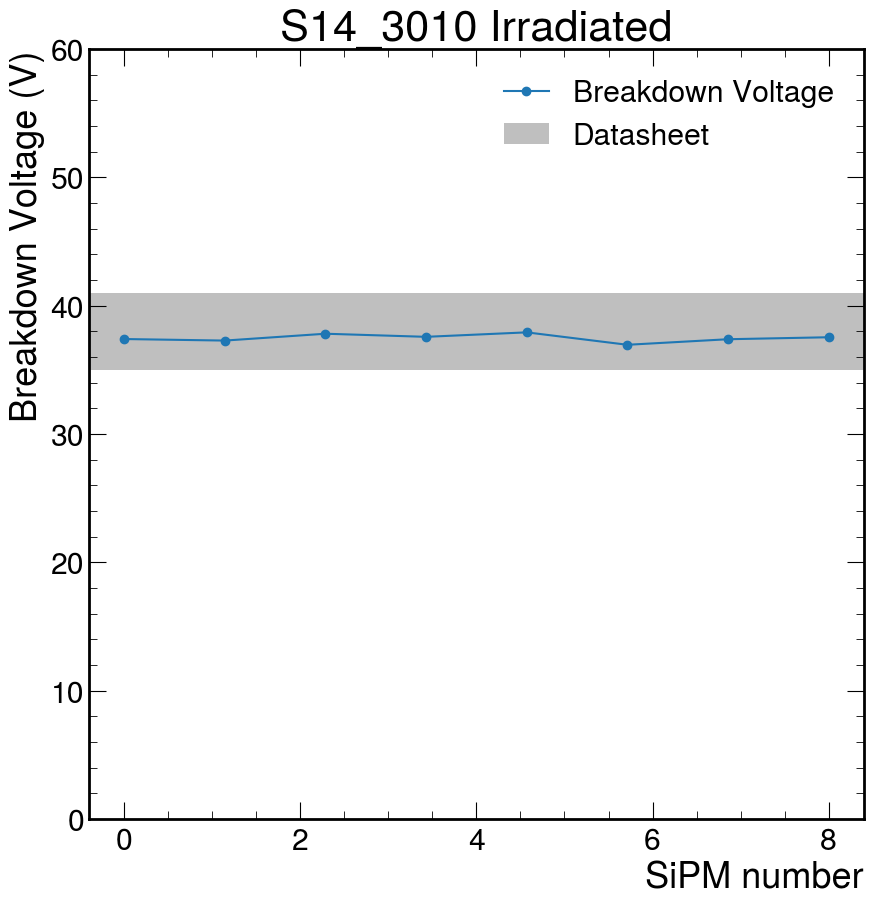

Processing S14_3010 IV_PreIrradiation


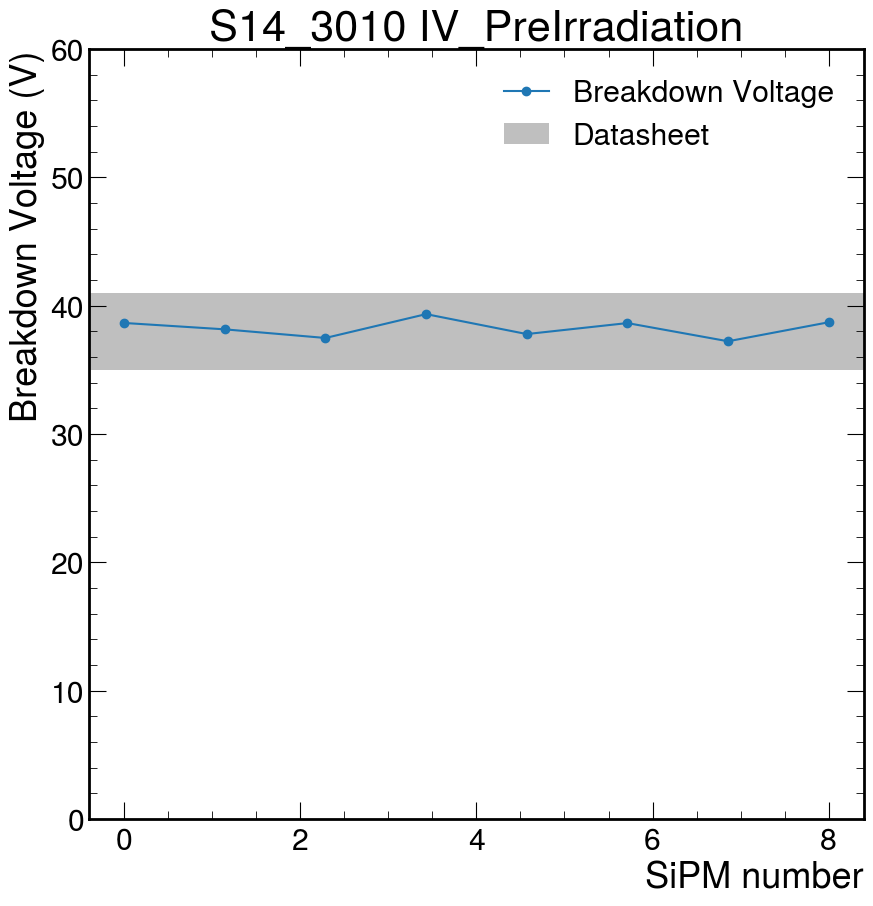

Processing JF_6015 Irradiated


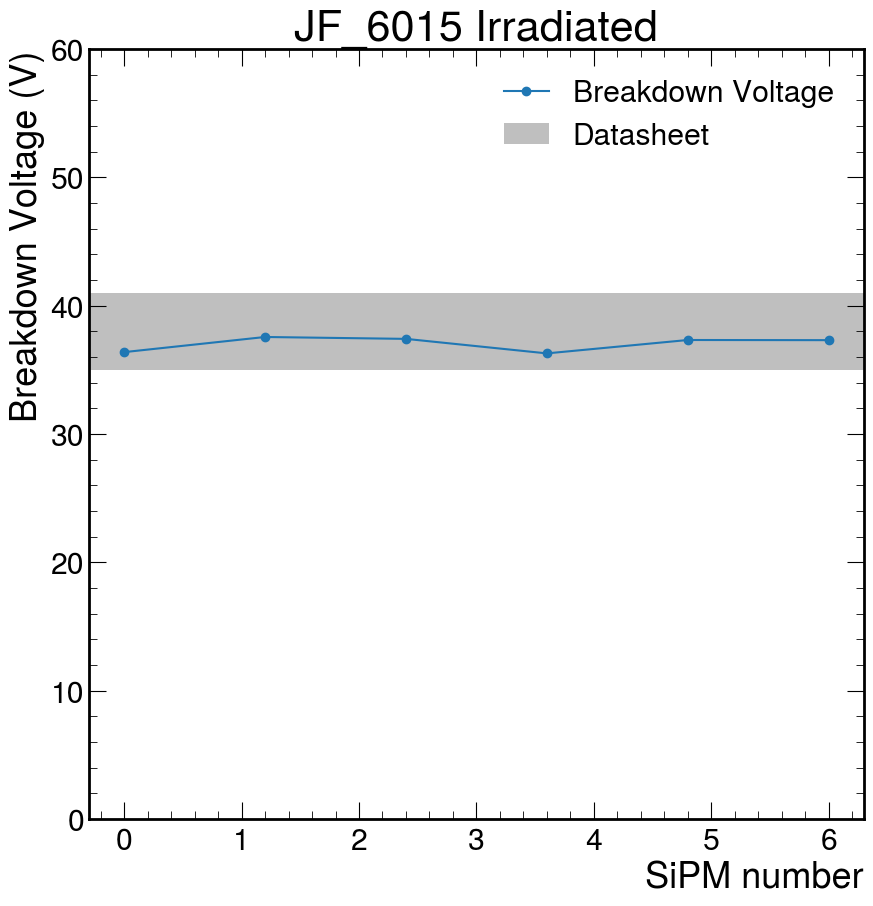

Processing JF_6015 IV_PreIrradiation


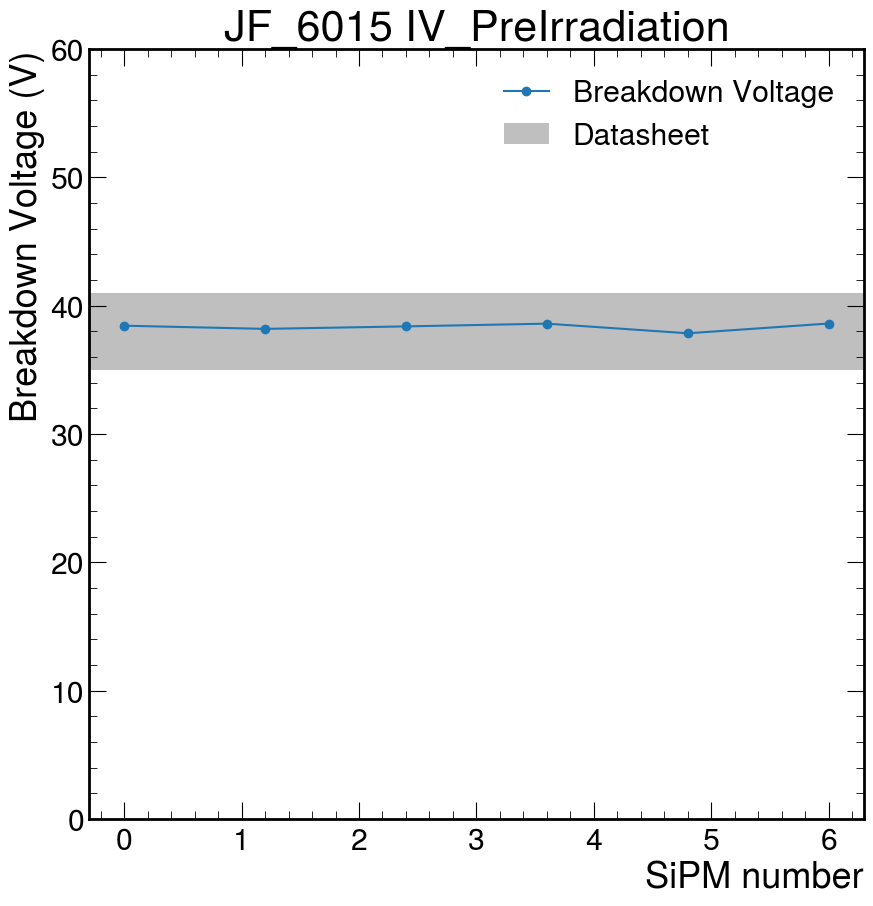

Processing JF_3015 Irradiated


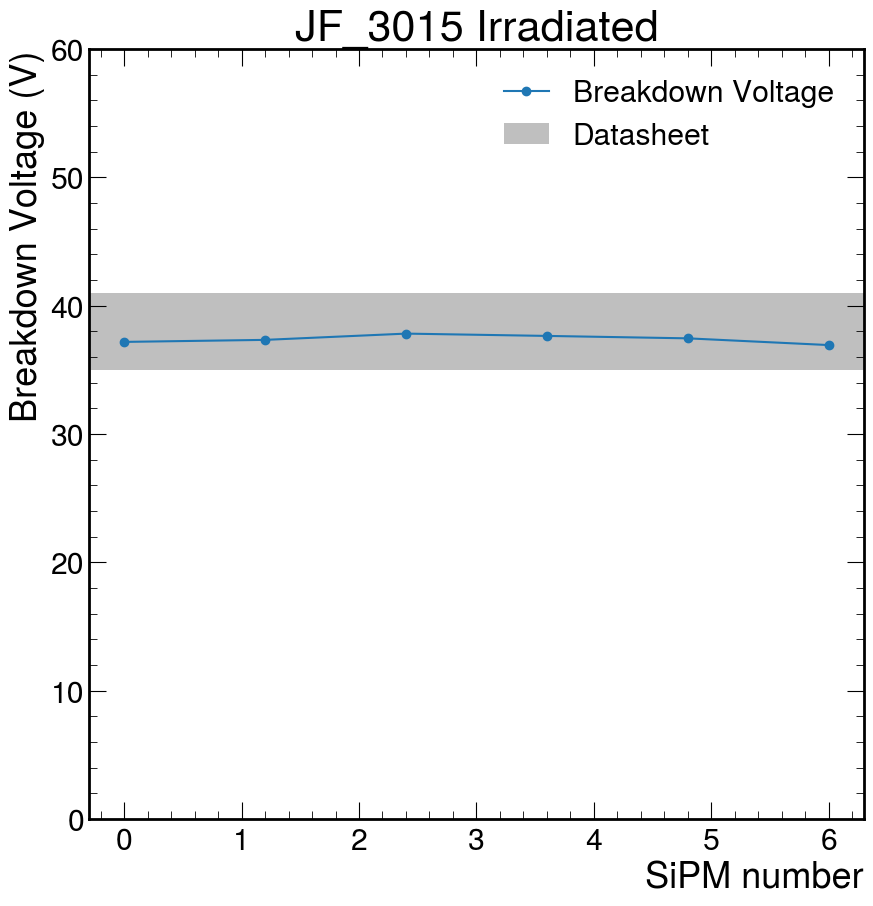

Processing JF_3015 IV_PreIrradiation


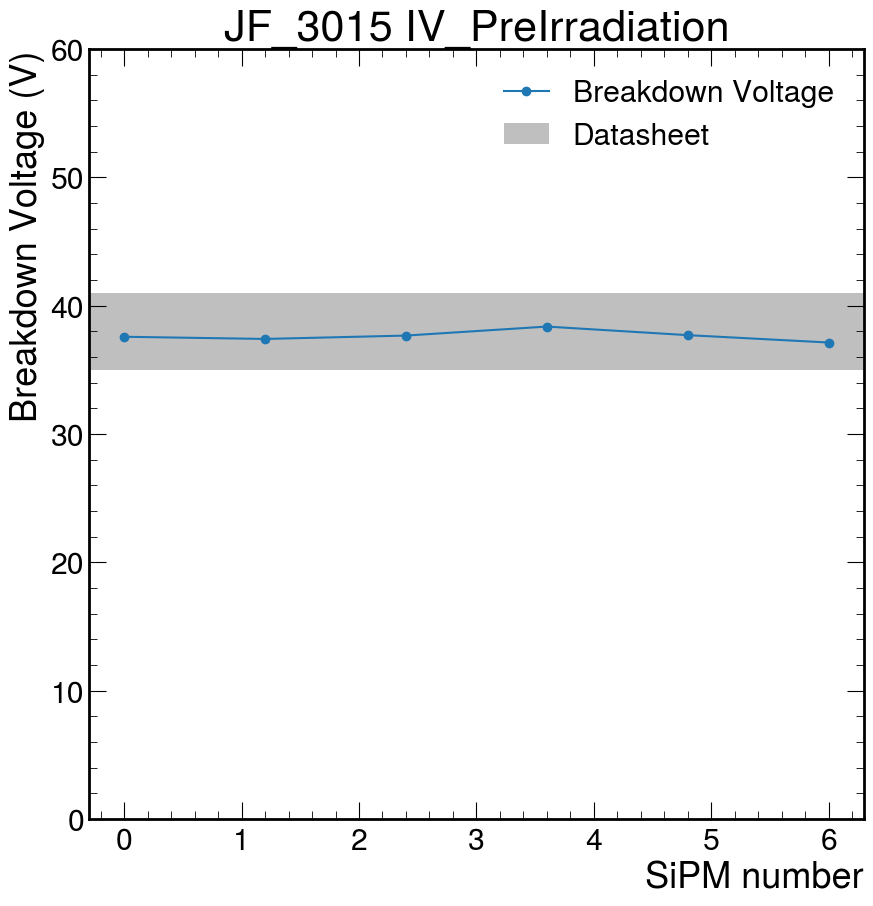

Processing S14_6015 Irradiated


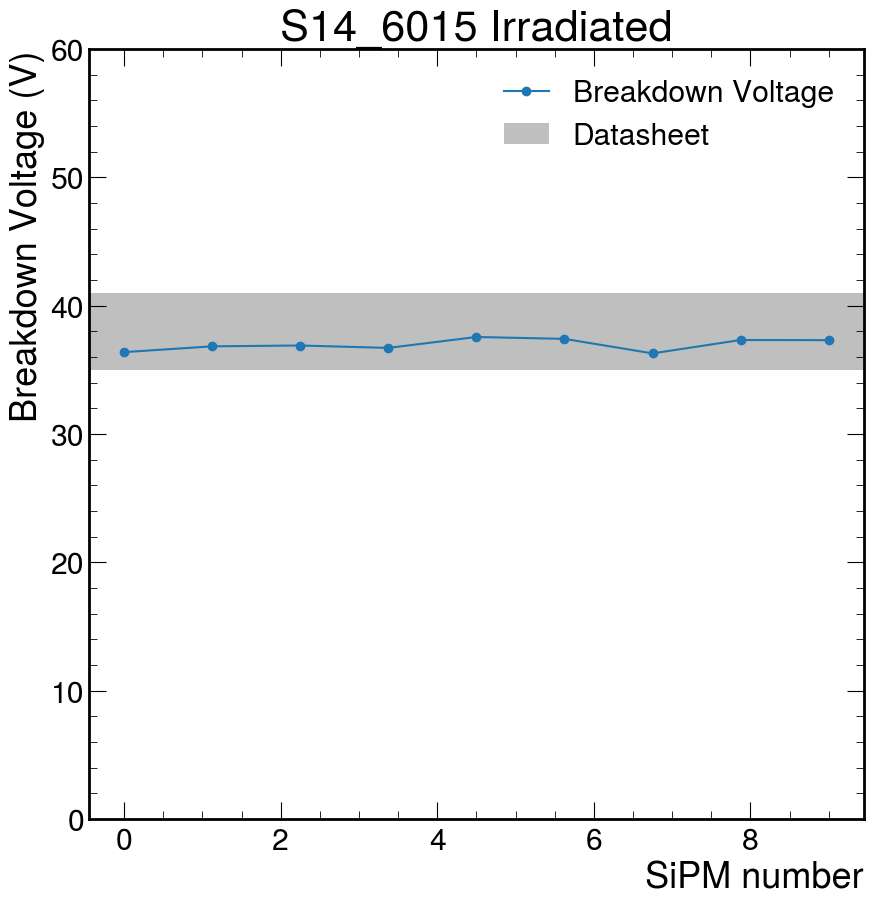

Processing S14_6015 IV_PreIrradiation


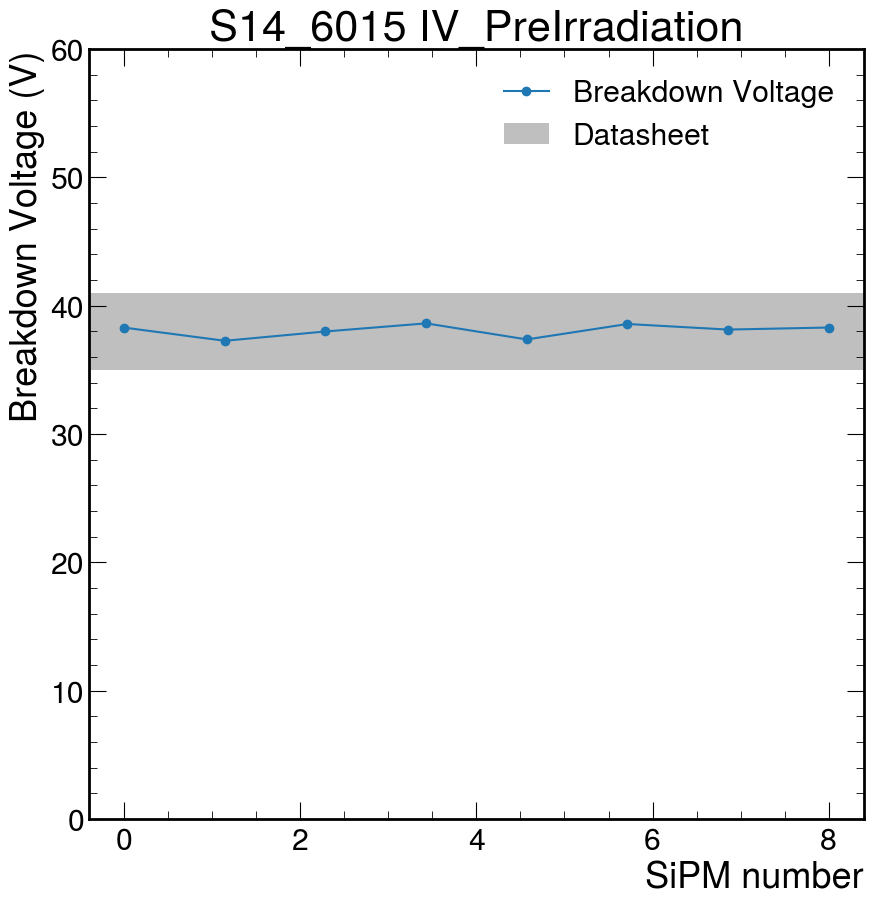

Processing S14_3015 Irradiated


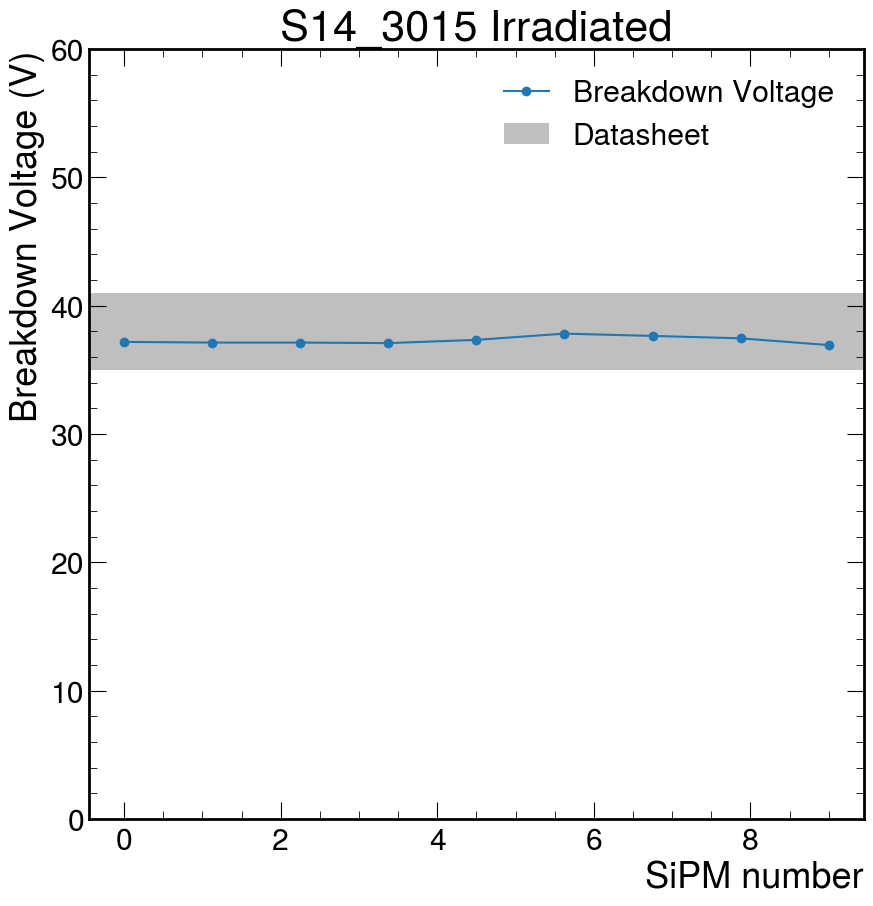

Processing S14_3015 IV_PreIrradiation


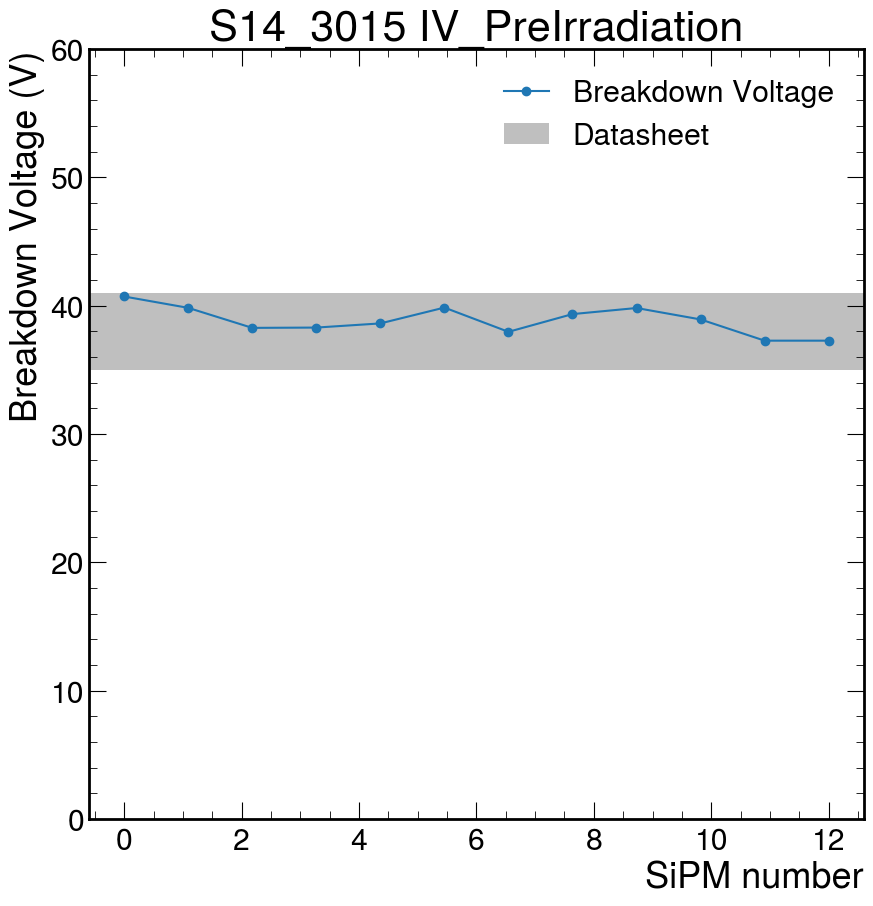

Processing S13_6050 Irradiated


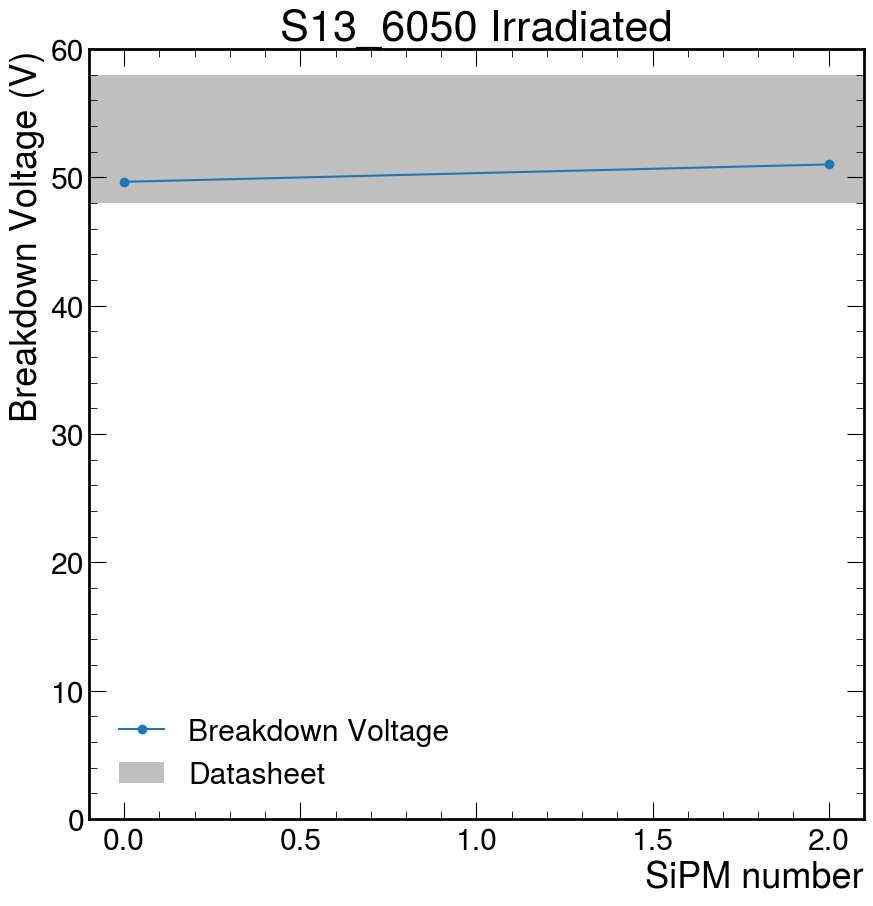

Processing S13_6050 IV_PreIrradiation


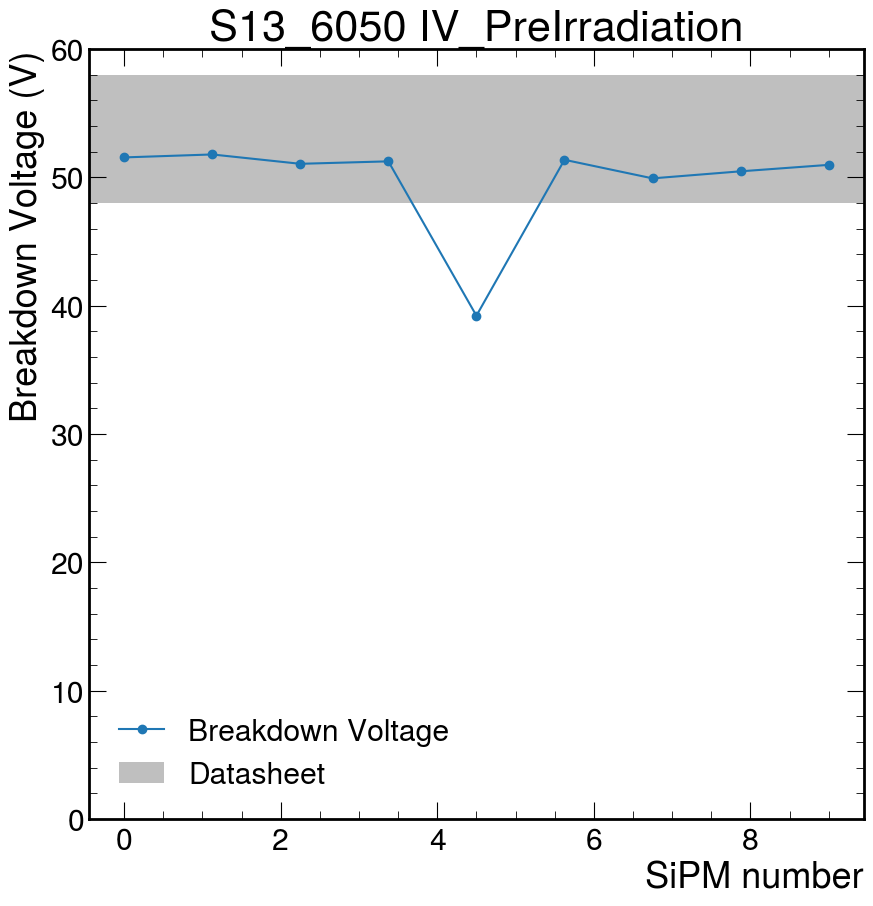

Processing FlowerBoard Irradiated


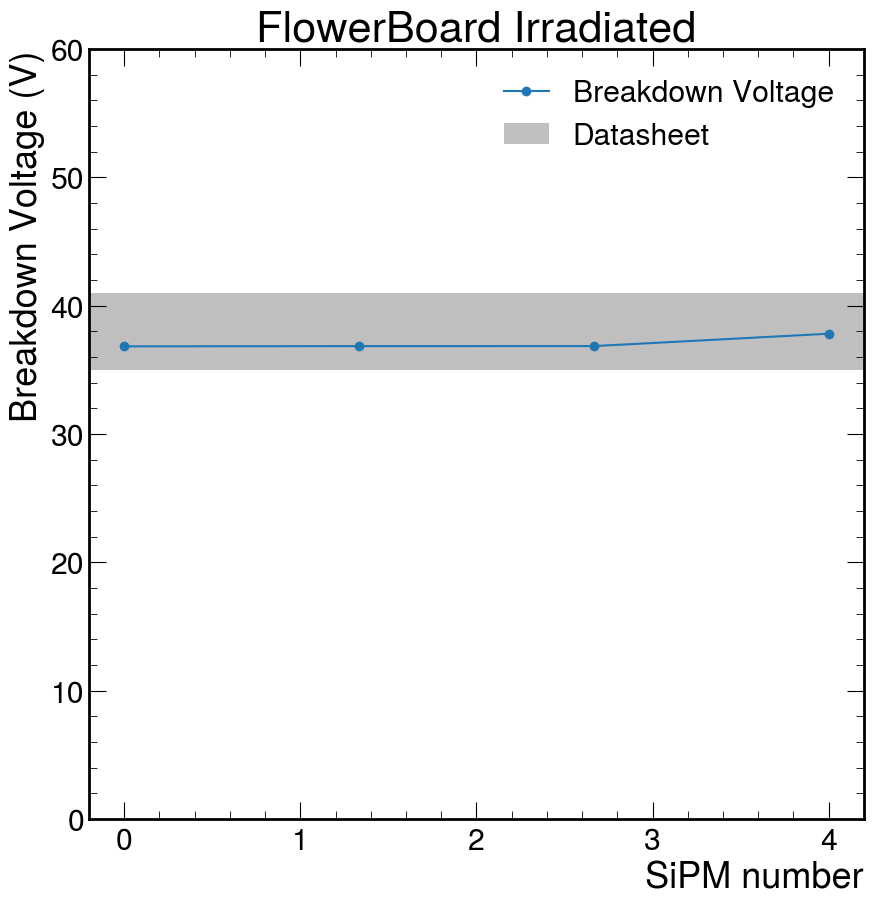

Processing FlowerBoard IV_PreIrradiation


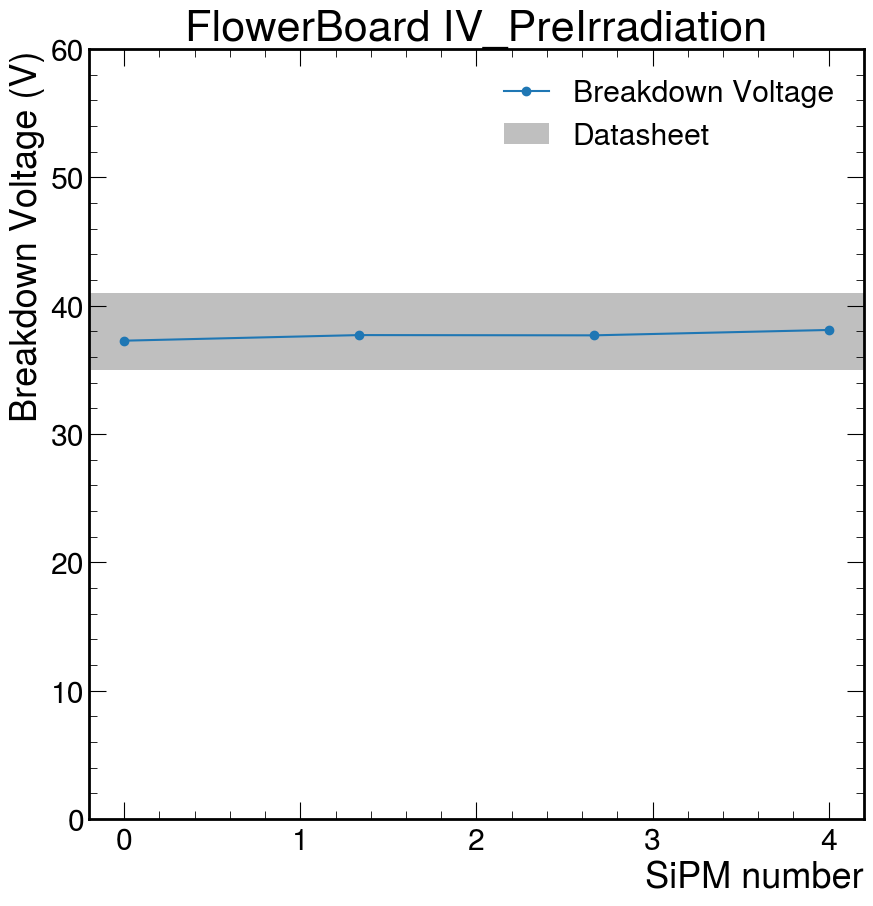

Processing S14_6050 Irradiated


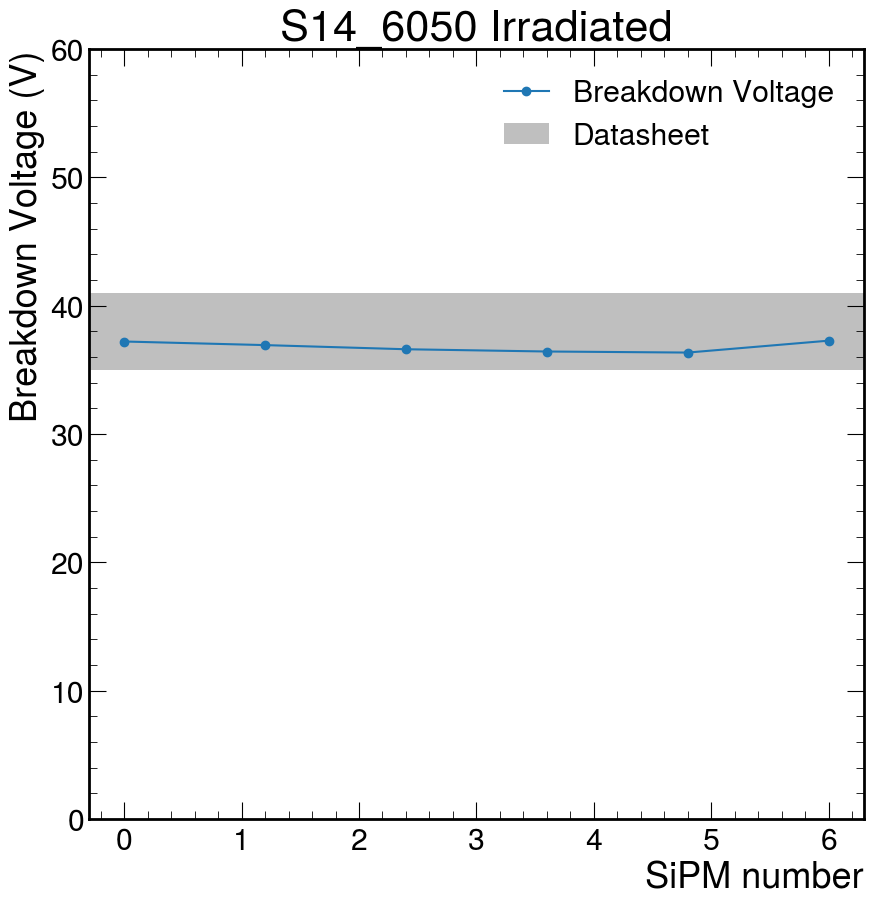

Processing S14_6050 IV_PreIrradiation


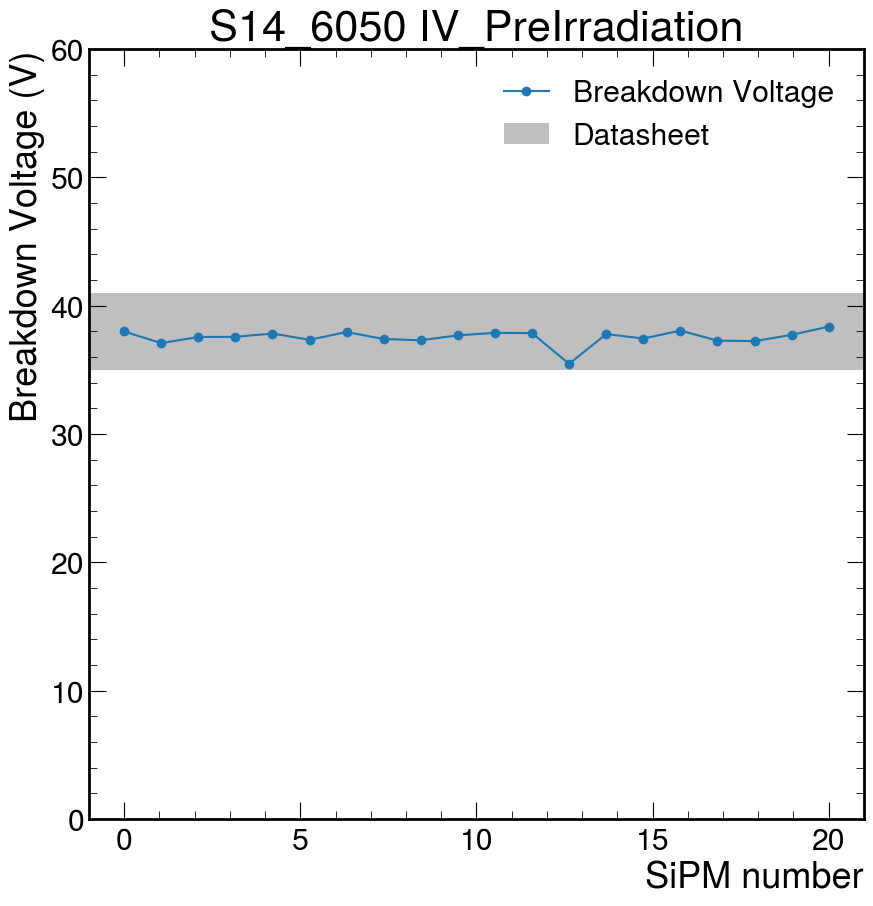

In [197]:
sipm_type = os.listdir(directory)

for type in sipm_type:
    sipm_test = os.listdir(directory + os.sep + type)
    Current = []
    Voltage = []
    time = []
    sipm_id = []
    status = []
    Breakdown = []
    fluence = []
    darkI = []
    for test in sipm_test:
        print('Processing ' + type + ' ' + test, flush=True)
        datasheet = 53 if type.split('_')[0] == 'S13' else 38
        datasheet_error = 5 if type.split('_')[0] == 'S13' else 3
        files = sorted(os.listdir(directory + os.sep + type + os.sep + test))
        if len(files) == 0:
            continue
        BV = []
        BV1 = []
        BV2 = []
        BV3 = []
        BV4 = []
        BV5 = []
        BV6 = []
        avgBV = []
        for i in enumerate(files):
            if f == '.ipynb_checkpoints':
                pass
            f = i[1]
            id = str(f.split('_')[0])
            if test == 'Irradiated':
                fluence.append(float(re.split('_|[A-Z]+',id)[-1]))
            else:
                fluence.append(0)
            sipm_id.append(id.split('_')[0])
            timestamp = f.split('UTC_')[1].split('.txt')[0]
            status.append(test)
            with open(directory + os.sep + type + os.sep + test + os.sep + f,'r') as file:
                lines = file.read().split(',')
            voltage = lines[::2]
            current = lines[1::2]
            
            voltage = np.array(list(map(float, voltage[1:])))
            current = np.array(list(map(float, current[1:])))
            Voltage.append(voltage)
            Current.append(current)
            
            yyyymmdd = list(timestamp.split('__')[0])
            month = yyyymmdd[4]+yyyymmdd[5]
            day = yyyymmdd[6]+yyyymmdd[7]
            hour = f.split('UTC_')[1].split('.txt')[0].split('__')[1].split('_')[0]
            minute = f.split('UTC_')[1].split('.txt')[0].split('__')[1].split('_')[1]   
            
            time.append(datetime(2024, int(month), int(day), int(hour), int(minute), tzinfo=timezone.utc))
            
            breakdown = 0
            
            plt.title(f'{test} {f}')
            plt.xlabel('Voltage (V)')
            plt.ylabel('Current (A)')
            
            plt.plot(voltage,current,label='Raw Data')

            index = 0
            for vol in enumerate(voltage):
                if (51 if type.split('_')[0] == 'S13' else 37) - vol[1] > 0:
                    index += 1

            cutoff = index-10
            fit, cov = curve_fit(quad, voltage[cutoff:], current[cutoff:], sigma=current[cutoff:])
            #plt.plot(voltage,quad(np.array(voltage), *fit),label='Quadratic Fit')
            
            baseline = sum(current[1:index])/len(current[1:index])
            #plt.axhline(baseline,label='Baseline',c='g')
            
            breakV = (-fit[1] + np.sqrt(fit[1]**2 - 4 * fit[0] * (fit[2] - baseline))) / 2 / fit[0]
            
            #plt.scatter(breakV, quad(breakV, *fit), label=f'Breakdown Voltage: {breakV:.2f}')
            BV4.append(breakV)
            breakdown += breakV

            breakV = -fit[1]/2/fit[0]
            BV5.append(breakV)
            #plt.scatter(-fit[1]/2/fit[0], quad(-fit[1]/2/fit[0], *fit), label=f'Breakdown Voltage: {-fit[1]/2/fit[0]:.2f}')
            breakdown += breakV
            
            dIdV = (current[1:]-current[:-1])/(voltage[1:]-voltage[:-1])/((current[1:]+current[:-1])/2)
            #dIdV = (current[1:]-current[:-1])/(voltage[1]-voltage[0])/((current[1:]+current[:-1])/2)
            #dIdV = scipy.ndimage.gaussian_filter(dIdV,1)
            breakV = voltage[np.argmax(dIdV)]/2+voltage[np.argmax(dIdV)+1]/2
            BV.append(breakV)
            #plt.plot((voltage[1:]+voltage[:-1])/2,dIdV/1E8,label=r'Method $\frac{\frac{dI}{dV}}{I}$')
            breakdown += breakV

            dIdV = (current[1:]-current[:-1])/(voltage[1:]-voltage[:-1])/((current[1:]+current[:-1])/2)**2
            breakV = voltage[np.argmax(dIdV)]/2+voltage[np.argmax(dIdV)+1]/2
            BV1.append(breakV)
            #plt.plot((voltage[1:]+voltage[:-1])/2,dIdV/1E16,label=r'Method $\frac{\frac{dI}{dV}}{I^2}$')
            breakdown += breakV

            dIdV = (current[1:]-current[:-1])/(voltage[1:]-voltage[:-1])/((current[1:]+current[:-1])/2)**5
            breakV = voltage[np.argmax(dIdV)]/2+voltage[np.argmax(dIdV)+1]/2
            BV2.append(breakV)
            #plt.plot((voltage[1:]+voltage[:-1])/2,dIdV/1E39,label=r'Method $\frac{\frac{dI}{dV}}{I^5}$')
            breakdown += breakV

            current_smooth = scipy.ndimage.gaussian_filter(current,5)
            dIdV = (current_smooth[1:]-current_smooth[:-1])/(voltage[1:]-voltage[:-1])/((current_smooth[1:]+current_smooth[:-1])/2)**5
            breakV = voltage[np.argmax(dIdV)]/2+voltage[np.argmax(dIdV)+1]/2
            breakdown += breakV
            BV3.append(breakV)
            #plt.plot((voltage[1:]+voltage[:-1])/2,dIdV/1E39,label=r'Method Gaussian Smoothed Current + $\frac{\frac{dI}{dV}}{I^5}$')

            current_1 = scipy.ndimage.gaussian_filter(current,1)
            dIdV = (np.log(current_1[1:])-np.log(current_1[:-1]))/(voltage[1:]-voltage[:-1])
            #plt.plot((voltage[1:]+voltage[:-1])/2,dIdV/1E12,label=r'Method $\frac{d(log(I))}{dV}$')
            breakV = voltage[np.argmax(dIdV)]/2+voltage[np.argmax(dIdV)+1]/2
            BV6.append(breakV)
            plt.axvline(breakV,c='black',label=f'Breakdown Voltage: {breakV:.2f} V')
            
            breakdown = breakdown / 6

            avgBV.append(breakdown)
            
            plt.axvline(breakdown,c='r',label=f'Breakdown Voltage: {breakdown:.2f} V')
            
            plt.legend()
            plt.yscale('log')

            #if os.path.isfile(directory + os.sep + type + os.sep + test + os.sep + f + '.png'):
                #pass
            #else:
                #plt.savefig(directory + os.sep + type + os.sep + test + os.sep + f + '.png')

            #plt.show()    ### Single IV with variouse methods of determining breakdown voltage
            plt.close()

            OV_I = []
            for j in range(10):
                index = 0
                
                for vol in enumerate(voltage):
                    if ((breakV if test == 'Irradiated' else breakdown) + j*0.5 - 1.5) - vol[1] > 0:
                        index += 1
                OV_I.append(current[index])
            darkI.append(OV_I)
            Breakdown.append(breakdown)

        plt.title(f'{type} {test}') # with method $\frac{\frac{dI}{dV}}{I}$
        '''
        plt.plot(np.linspace(0,len(BV),len(BV)),BV,marker='o',label=r'$\frac{\frac{dI}{dV}}{I}$')
        plt.plot(np.linspace(0,len(BV1),len(BV)),BV1,marker='o',label=r'$\frac{\frac{dI}{dV}}{I^2}$')
        plt.plot(np.linspace(0,len(BV2),len(BV)),BV2,marker='o',label=r'$\frac{\frac{dI}{dV}}{I^5}$')
        plt.plot(np.linspace(0,len(BV3),len(BV)),BV3,marker='o',label=r'Gaussian Smoothed Current + $\frac{\frac{dI}{dV}}{I^5}$')
        plt.plot(np.linspace(0,len(BV4),len(BV)),BV4,marker='o',label=r'Quadratic Fit + Baseline')
        plt.plot(np.linspace(0,len(BV5),len(BV)),BV5,marker='o',label=r'Quadratic Fit Derivative = 0')
        plt.plot(np.linspace(0,len(BV6),len(BV)),BV6,marker='o',label=r'$\frac{d(log(I))}{dV}$')
       '''
        plt.plot(np.linspace(0,len(avgBV),len(BV)),avgBV,marker='o',label=r'Breakdown Voltage')
        plt.axhspan(datasheet-datasheet_error,datasheet+datasheet_error,facecolor='grey',label=rf"Datasheet", alpha=0.5)
        
        plt.ylim(0,60)
        plt.xlabel('SiPM number')
        plt.ylabel('Breakdown Voltage (V)')
        plt.legend()
        #plt.show()    #### Breakdown voltage per sipm with other methods
        plt.close()
        
    for id in set(sipm_id):
        plt.title(type+' Fluence = 10^'+re.split('_|[A-Z]',id)[1]+r' $N_{{p^+}}$')
        plt.ylabel(r'Current ($\mu$A)')
        plt.xlabel('Voltage (V)')
        starttime = datetime(2024, 5, 14, 9, 0, tzinfo=timezone.utc)
        plt.plot(np.array(Voltage)[(np.char.find(sipm_id,id)==0)][-1],(np.array(Current)[(np.char.find(sipm_id,id)==0)][-1])*1000000,c='black',label='Pre-Irradiation')
        for i in range(len(np.array(Voltage)[(np.char.find(sipm_id,id)==0)])-1):
            ts = np.array(time)[(np.char.find(sipm_id,id)==0)][i] - starttime
            tdelta = ''
            if ts.days == 0:
                tdelta = f'{ts.seconds//3600} Hours'
            else: 
                tdelta = f'{ts.days} Day'
            plt.plot(np.array(Voltage)[(np.char.find(sipm_id,id)==0)][i],(np.array(Current)[np.char.find(sipm_id,id)==0][i])*1000000,label=tdelta)
        plt.yscale('log')
        plt.legend()
        #plt.show()    ### IV curve per sipm with differen data-taking time
        plt.close()

    starttime = datetime(2024, 5, 14, 17, 0, tzinfo=timezone.utc)
    for id in enumerate(np.array(sipm_id)[np.char.find(status,'Irradiated')==0]):
        ts = time[id[0]] - starttime
        tdelta = ''
        if ts.days == 0:
            tdelta = f'{ts.seconds//3600} Hours'
        else: 
            tdelta = f'{ts.days} Day'
        label = '10^'+re.split('_|[A-Z]',id[1])[1]+rf' $N_{{p^+}}$ : {tdelta} : BV = {Breakdown[id[0]]:.2f} V'
        plt.plot(Voltage[id[0]],np.array(Current[id[0]])*1000000,label=label)
    plt.title(f'{type} Irradiated IV')
    plt.xlabel('Voltage (V)')
    plt.ylabel(r'Current ($\mu$A)')
    plt.legend()
    #plt.yscale('log')
    #plt.show()    ### All irradiated IV curve per each type of sipm
    plt.close()
        
    for i in range(10):
        fluences = []
        avgI = []
        errI = []
        for j in sorted(set(fluence)):
            fluences.append(j)
            avg = np.array(darkI)[np.array(fluence)==j][:,i]
            avgI.append(sum(avg)/len(avg))
            errI.append(np.std(avg))
        plt.errorbar(fluences,np.array(avgI)*1000000,yerr=errI,label=fr'$V_{{OV}}$ = {i*0.5 - 1.5} V',fmt='-o')
    plt.legend()
    plt.xlabel(r'log(Fluence) (log($N_{p^+}$/$cm^2$))')
    plt.ylabel(r'Dark Current ($\mu$A)')
    plt.title(type)
    plt.yscale('log')
    #plt.show()    ### Averged dark current per fluence
    plt.close()

    flu_i = []
    flu = []
    flu_err = []
    for i in sorted(set(fluence)):
        flu_i.append(i)
        condition = np.array(fluence)==i
        flu.append(sum(np.array(Breakdown)[condition])/len(np.array(Breakdown)[condition]))
        flu_err.append(np.std(np.array(Breakdown)[condition]))
    plt.errorbar(flu_i,flu,yerr=flu_err,fmt='-o',label=f'{type}')
    plt.axhspan(datasheet-datasheet_error,datasheet+datasheet_error,facecolor='grey',label=rf"Datasheet", alpha=0.5)
    plt.xlabel(r'log(Fluence) (log($N_{p^+}$/$cm^2$))')
    plt.ylabel(r'Breakdown Voltage (V)')
    plt.ylim(30,60)
    plt.legend()
    #plt.show()    ### Fluence vs. breakdown voltage 
    plt.close()